# Activation Foil Analysis: 1L BABY Run #8

This notebook processes the calibration data from HPGe detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [1]:
# parameters

## keep this if statement for ci and process workflows
if 'download_from_raw' not in globals() and 'download_from_raw' not in locals():
    download_from_raw = True

In [2]:
import numpy as np
from datetime import datetime
import json

In [ ]:
from process_foil_data import get_data
check_source_measurements, background_meas, foil_measurements = get_data(download_from_raw=download_from_raw,
                                                                         h5_filename="activation_data.h5")

{'HPGe': '251119_1L_BABY_FLiBe_Run1_HPGe/DAQ', 'NaI': '20251119_1L_BABY_FLiBe_Run1_NaI/DAQ'}
Multiple measurement directories found.
Multiple data URLs found.
measurement_directory_path:  {'HPGe': PosixPath('../../data/neutron_detection/activation_foils/251119_1L_BABY_FLiBe_Run1_HPGe/DAQ'), 'NaI': PosixPath('../../data/neutron_detection/activation_foils/20251119_1L_BABY_FLiBe_Run1_NaI/DAQ')}
key:  HPGe
measurement_directory_path[d_type]:  ../../data/neutron_detection/activation_foils/251119_1L_BABY_FLiBe_Run1_HPGe/DAQ
Read in properties of Niobium Packet #1 foil
Read in properties of Niobium Packet #2 foil
Read in properties of Zr Packet #2 foil
Read in properties of Zr Packet #3 foil
Directory already exists: ../../data/neutron_detection/activation_foils
Processing Ba133 Count 1...
Processing File 0
Processing Ba133 Count 2...
Processing File 0
Processing Co60 Count 1...
Processing File 0
Processing File 1
Processing File 2
Processing File 3
Processing File 4
Processing File 5
Process

## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

Detector type: HPGe
  Measurement: Ba133 Count 1, Nuclide: Ba133
Axes(0.125,0.11;0.775x0.77)
[]
Peaks found: [255 304 404 459]
peak_data: {'peak_heights': array([1669., 2871., 9122., 1094.]), 'prominences': array([1540., 2797., 9077., 1079.]), 'left_bases': array([224, 292, 367, 446]), 'right_bases': array([292, 367, 656, 656]), 'widths': array([5.31041181, 6.60716325, 5.59868878, 6.50623163]), 'width_heights': array([ 899. , 1472.5, 4583.5,  554.5]), 'left_ips': array([252.26282051, 300.72009202, 401.03268102, 456.14663462]), 'right_ips': array([257.57323232, 307.32725528, 406.6313698 , 462.65286624])}
  Measurement: Ba133 Count 2, Nuclide: Ba133
Axes(0.125,0.11;0.775x0.77)
[]
Peaks found: [255 304 404 460]
peak_data: {'peak_heights': array([ 2355.,  4121., 13332.,  1545.]), 'prominences': array([ 2198.,  3988., 13269.,  1522.]), 'left_bases': array([208, 293, 371, 448]), 'right_bases': array([293, 371, 792, 792]), 'widths': array([5.29419332, 6.38952909, 5.65386577, 6.70219151]), 'wi

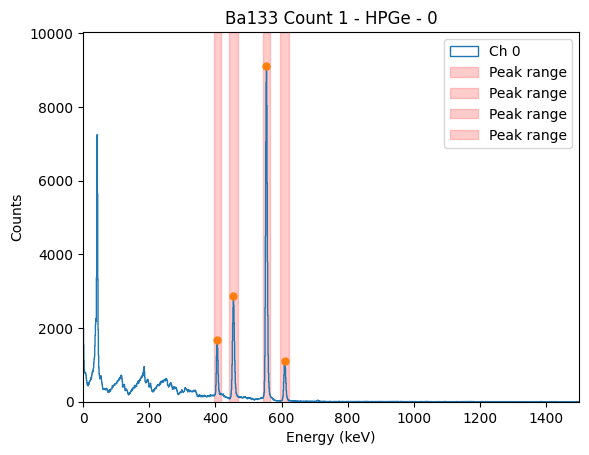

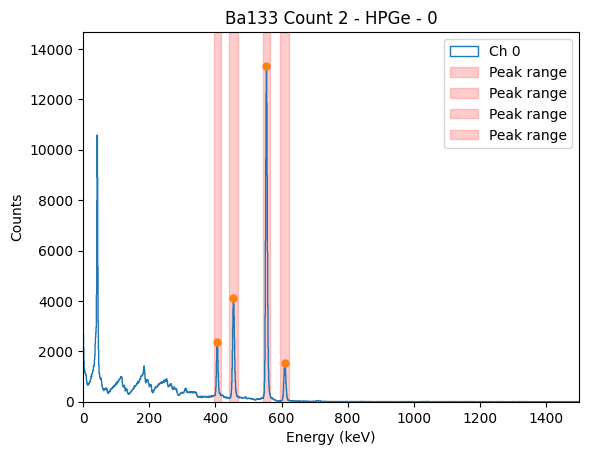

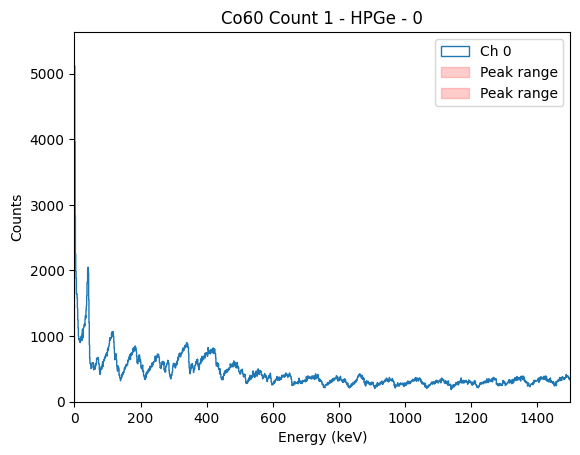

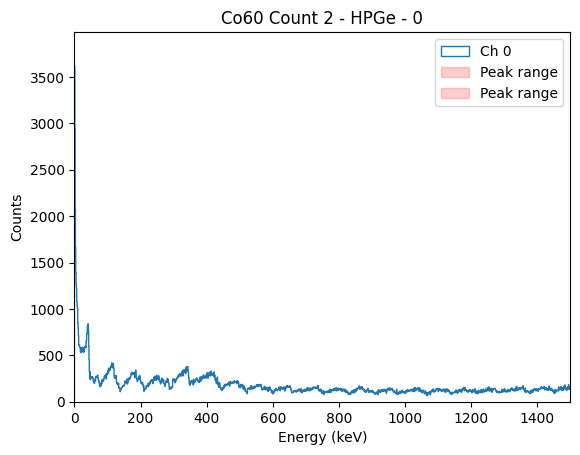

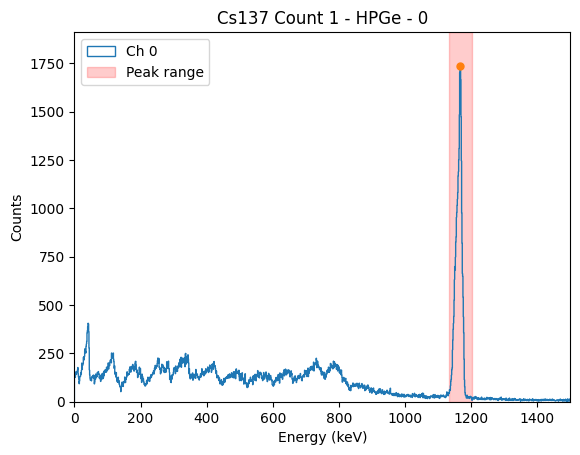

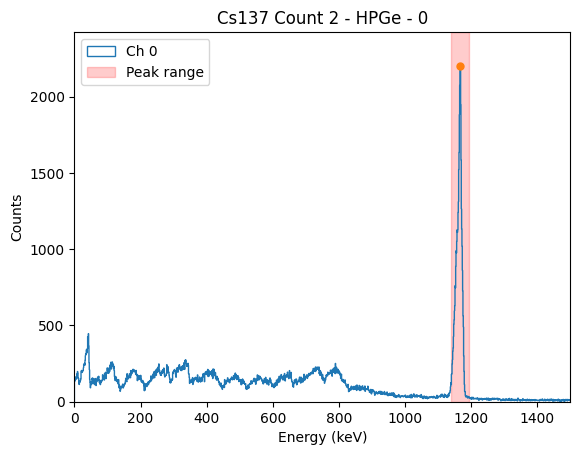

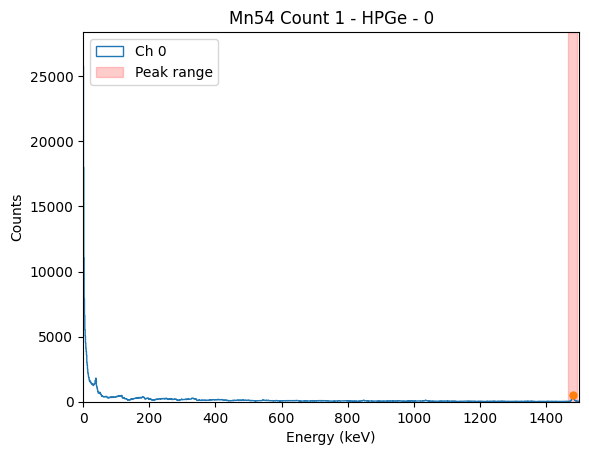

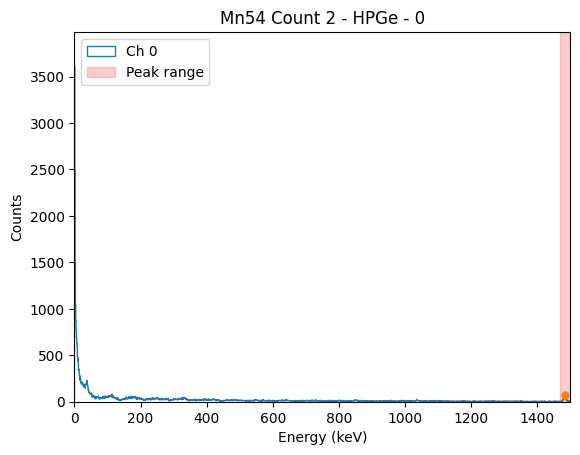

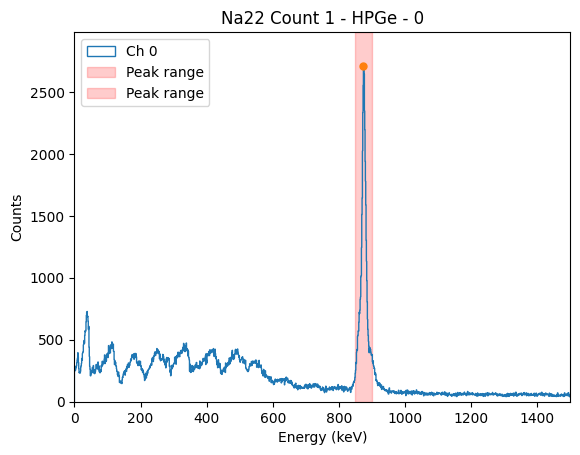

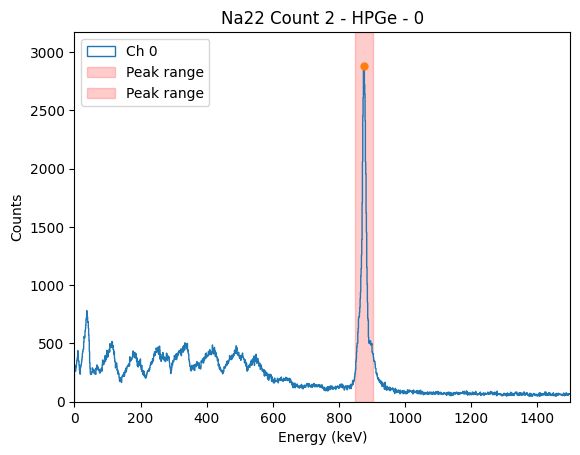

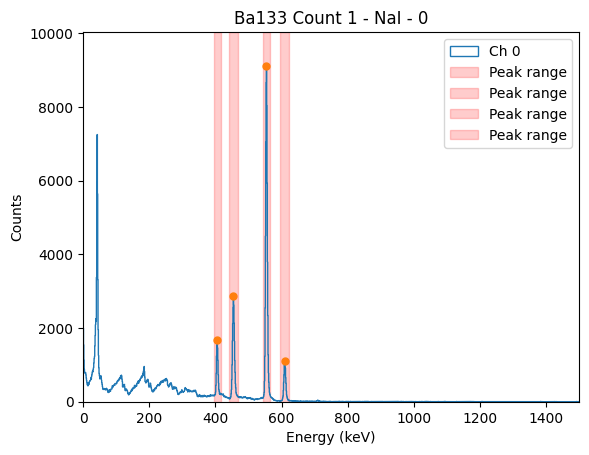

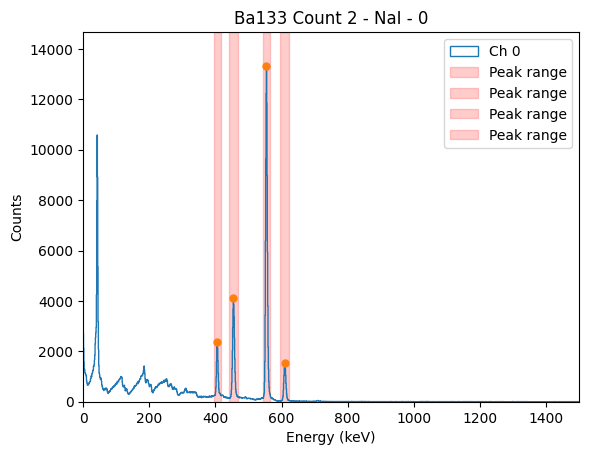

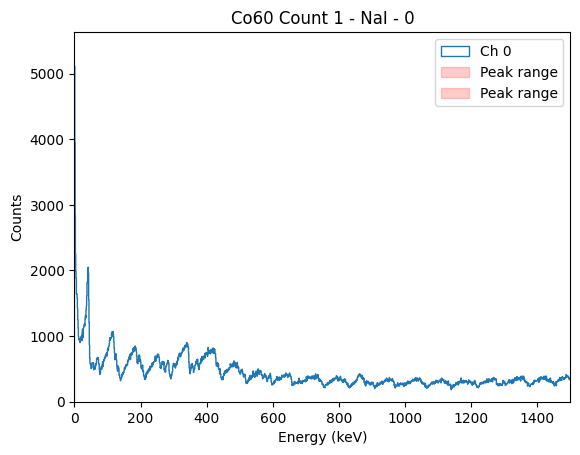

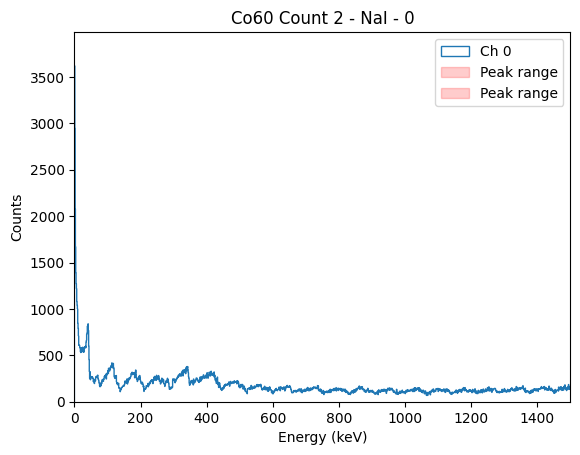

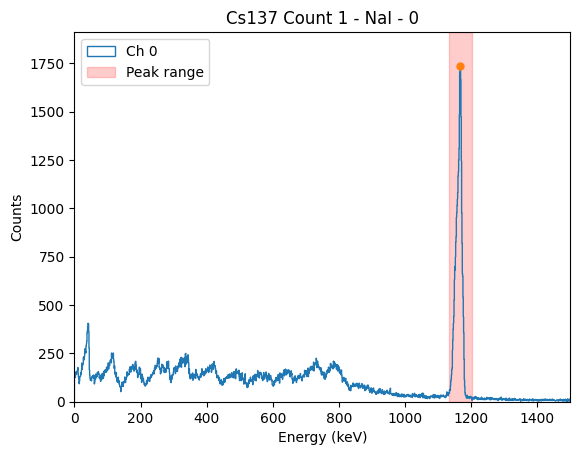

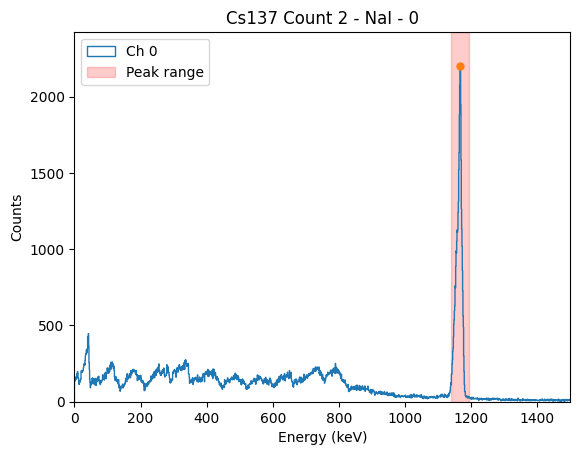

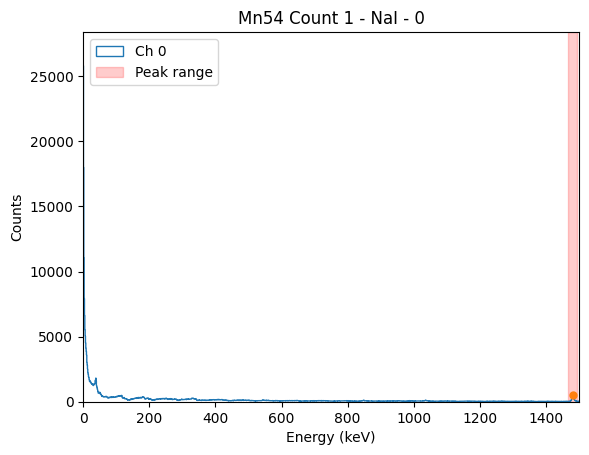

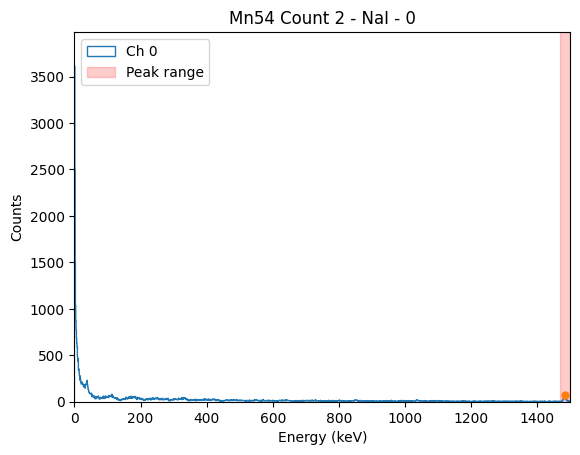

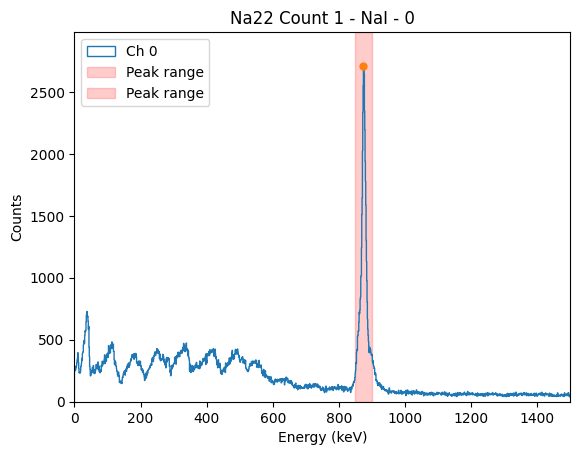

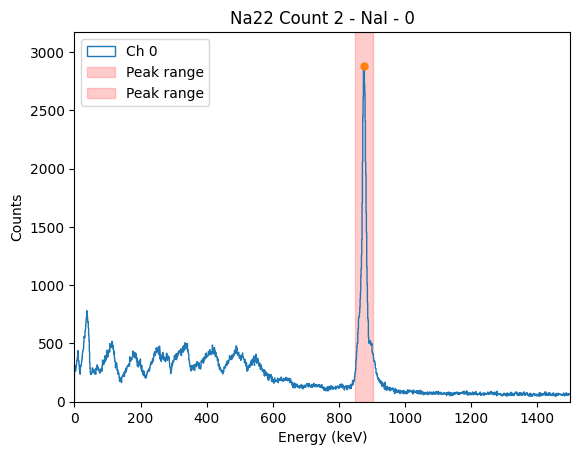

In [4]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass
peak_parameters = {
    "Ba133": {
        "start_index": 150,
        "height": 0.1,
        "prominence": 0.1,
        "width": [2, 150],
        "distance": 10,
    },
    "Na22": {
        "start_index": 100,
        "height": 0.2,
        "prominence": 0.2,
        "width": [2, 150],
        "distance": 100,
    },
    "Co60": {
        "start_index": 100,
        "height": 0.5,
        "prominence": 0.5,
        "width": [2, 150],
        "distance": 10,
    },
    "Cs137": {
        "start_index": 10,
        "height": 0.5,
        "prominence": 0.5,
        "width": [2, 150],
        "distance": 100,
    },
    "Mn54": {
        "start_index": 400,
        "height": 0.9,
        "prominence": 0.9,
        "width": [2, 150],
        "distance": 100,
    }
}
for detector_type, measurements in check_source_measurements.items():
    print(f"Detector type: {detector_type}")
    for name, measurement in measurements.items():
        print(f"  Measurement: {name}, Nuclide: {measurement.check_source.nuclide.name}")
        fig, ax = plt.subplots(nrows=1, ncols=len(measurement.detectors))
        print(ax)
        if ax is not np.ndarray:
            ax = [ax]
        ax = np.array(ax).flatten()
        for d,detector in enumerate(measurement.detectors):
            print(detector)
            # print(detector._spectrum)
            hist, bin_edges = detector.get_energy_hist()
            ax[d].hist(
                bin_edges[:-1],
                bins=bin_edges,
                weights=hist,
                histtype="step",
                label=f"Ch {detector.channel_nb}",
            )
            peaks = measurement.get_peaks(hist)
            print(peaks)

            from scipy.signal import find_peaks
            import numpy as np

            # Use the peak parameters for the specific measurement
            params = peak_parameters.get(measurement.check_source.nuclide.name, peak_parameters["Ba133"])
            start_index = params["start_index"]
            height = params["height"] * np.max(hist[start_index:])
            prominence = params["prominence"] * np.max(hist[start_index:])
            width = params["width"]
            distance = params["distance"]
            peaks, peak_data = find_peaks(
                hist[start_index:],
                prominence=prominence,
                height=height,
                width=width,
                distance=distance,
            )
            print("Peaks found:", peaks)
            print("peak_data:", peak_data)
            ax[d].plot(bin_edges[start_index:][peaks], peak_data["peak_heights"], ".", ms=10)

            if not hasattr(measurement.check_source.nuclide, "peak_widths") or measurement.check_source.nuclide.peak_widths is None:
                measurement.check_source.nuclide.peak_widths = {}
            measurement.check_source.nuclide.peak_widths[detector.channel_nb] = 3 * peak_data["widths"]

            for i, p in enumerate(peaks):
                width = peak_data["widths"][i]
                ax[d].axvspan(
                    bin_edges[start_index:][p] - width*2.0,
                    bin_edges[start_index:][p] + width*2.0,
                    color="red",
                    alpha=0.2,
                    label="Peak range",
                )
                # ax[d].axvspan(
                #     peak_data["right_bases"][i] + start_index,
                #     peak_data["left_bases"][i] + start_index,
                #     color="red",
                #     alpha=0.2,
                #     label="Peak range",
                # )

        ax[d].legend()
        # plt.yscale("log")
        ax[d].set_xlim(left=0, right=1500)
        ax[d].set_ylim(top=1.1 * np.max(hist))
        ax[d].set_title(f"{measurement.name} - {detector_type} - {detector.channel_nb}")
        ax[d].set_xlabel("Energy (keV)")
        ax[d].set_ylabel("Counts")
plt.show()

In [5]:
calibration_coeffs = {}
print(check_source_measurements)
for channel_nb in [0,1]:
    calibration_channels, calibration_energies = compass.get_calibration_data(
        check_source_measurements['NaI'].values(),
        background_measurement=background_meas['NaI'],
        channel_nb=channel_nb,
    )

    coeff = np.polyfit(calibration_channels, calibration_energies, 1)
    calibration_coeffs[channel_nb] = coeff

    xs = np.linspace(
        calibration_channels[0],
        calibration_channels[-1],
    )
    plt.plot(
        xs,
        np.polyval(coeff, xs),
        label=f"Ch {channel_nb} fit",
    )
    plt.scatter(
        calibration_channels,
        calibration_energies,
        label=f"Ch {channel_nb} data",
        alpha=0.5,
    )
plt.xlabel("Channel number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.show()

{'HPGe': {'Ba133 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf56c42f0>, 'Ba133 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf5ef2bd0>, 'Co60 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf5ac4710>, 'Co60 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf69aba10>, 'Cs137 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf56c7b90>, 'Cs137 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf56fad50>, 'Mn54 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf56fbb90>, 'Mn54 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x7f3cf570b

ValueError: SciPy find_peaks() found 0 photon peaks, while 5 were expected

In [ ]:
for measurement in check_source_measurements["NaI"].values():
    for detector in measurement.detectors:
        hist, bin_edges = detector.get_energy_hist()
        peaks = measurement.get_peaks(hist)
        print("measured peaks:", peaks)
        print("True peaks: ", measurement.check_source.nuclide.energy)
        measurement.check_source.nuclide.measured_energy = peaks

measured peaks: [1553 1766]
True peaks:  [1173.228, 1332.492]
measured peaks: [1046 1186]
True peaks:  [1173.228, 1332.492]
measured peaks: [1560 1764]
True peaks:  [1173.228, 1332.492]
measured peaks: [1035 1182]
True peaks:  [1173.228, 1332.492]
measured peaks: [913]
True peaks:  [661.657]
measured peaks: [606]
True peaks:  [661.657]
measured peaks: [910]
True peaks:  [661.657]
measured peaks: [603]
True peaks:  [661.657]
measured peaks: []
True peaks:  [834.848]
measured peaks: [742]
True peaks:  [834.848]
measured peaks: [1107]
True peaks:  [834.848]
measured peaks: [759]
True peaks:  [834.848]
measured peaks: [ 710 1720]
True peaks:  [511, 1274.537]
measured peaks: [ 473 1146]
True peaks:  [511, 1274.537]
measured peaks: [ 714 1717]
True peaks:  [511, 1274.537]
measured peaks: [ 472 1143]
True peaks:  [511, 1274.537]


In [ ]:
for measurement in check_source_measurements["NaI"].values():
    measurement.check_source.nuclide.calibrated_peak_widths = {}
    for detector in measurement.detectors:
        width_calibration_coeffs = np.append(calibration_coeffs[detector.channel_nb][:-1], 0)

        measurement.check_source.nuclide.calibrated_peak_widths[detector.channel_nb] = np.polyval(width_calibration_coeffs,
                                                                      measurement.check_source.nuclide.peak_widths[detector.channel_nb])

AttributeError: 'Nuclide' object has no attribute 'peak_widths'

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [ ]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

In [ ]:
from scipy.optimize import curve_fit

def gauss(x, b, m, *args):
    """Creates a multipeak gaussian with a linear addition of the form:
    m * x + b + Sum_i (A_i * exp(-(x - x_i)**2) / (2 * sigma_i**2)"""

    out = m * x + b
    if np.mod(len(args), 3) == 0:
        for i in range(int(len(args) / 3)):
            out += args[i * 3 + 0] * np.exp(
                -((x - args[i * 3 + 1]) ** 2) / (2 * args[i * 3 + 2] ** 2)
            )
    else:
        raise ValueError("Incorrect number of gaussian arguments given.")
    return out


def fit_peak_gauss(hist, xvals, peak_ergs, search_width=600, threshold_overlap=200, axes=None):

    if len(peak_ergs) > 1:
        if np.max(peak_ergs) - np.min(peak_ergs) > threshold_overlap:
            raise ValueError(
                f"Peak energies {peak_ergs} are too far away from each to be fitted together."
            )

    search_start = np.argmin(
        np.abs((peak_ergs[0] - search_width / ( len(peak_ergs))) - xvals)
    )
    search_end = np.argmin(
        np.abs((peak_ergs[-1] + search_width / (len(peak_ergs))) - xvals)
    )

    slope_guess = (hist[search_end] - hist[search_start]) / (
        xvals[search_end] - xvals[search_start]
    )

    # guess_parameters = [0, slope_guess]
    guess_parameters = [0, 0]

    for i in range(len(peak_ergs)):
        peak_ind = np.argmin(np.abs((peak_ergs[i]) - xvals))
        print("Notebook: Peak index:", peak_ind, "Peak energy:", peak_ergs[i], "Peak height:", hist[peak_ind])
        guess_parameters += [
            hist[peak_ind],
            peak_ergs[i],
            search_width / (3 * len(peak_ergs)),
        ]

    if axes is not None:
        axes.plot(
            xvals[search_start:search_end],
            gauss(xvals[search_start:search_end], *guess_parameters),
            "--",
            label="Initial guess",
        )
        axes.axvspan(
            xvals[search_start],
            xvals[search_end],
            color="red",
            alpha=0.2,
            label="Peak range",
        )
    print('Notebook: Search start:', search_start, ' Search end:', search_end)
    print("Notebook: Guess parameters:", guess_parameters)

    parameters, covariance = curve_fit(
        gauss,
        xvals[search_start:search_end],
        hist[search_start:search_end],
        p0=guess_parameters,
    )

    return parameters, covariance, search_start, search_end


def get_multipeak_area(
    hist, bins, peak_ergs, search_width=600, threshold_overlap=200, axes=None
):
    print("search_width:", search_width)
    if len(peak_ergs) > 1:
        if np.max(peak_ergs) - np.min(peak_ergs) > threshold_overlap:
            areas = []
            for p, peak in enumerate(peak_ergs):
                if isinstance(search_width, (np.ndarray, list)):
                    search_w = int(search_width[p])
                    print("search_width is an array, using value for peak", p, ":", search_w)
                else:
                    print("search_width is not an array, using single value")
                    search_w = int(search_width)
                print("peak", peak, "search_w:", search_w)
                area = get_multipeak_area(
                    hist,
                    bins,
                    [peak],
                    search_width=search_w,
                    threshold_overlap=threshold_overlap,
                    axes=axes
                )
                areas += area
            return areas
    if isinstance(search_width, (np.ndarray, list)):
        search_width = int(search_width[0])
        print("search_width is an array, using first value:", search_width)

    # get midpoints of every bin
    xvals = np.diff(bins) / 2 + bins[:-1]
    print("notebook bins length:", len(bins))
    print("notebook xvals:", xvals)
    print("notebook hist[0, -1]: ", hist[0], hist[-1])
    print("notebook peak_ergs:", peak_ergs)


    parameters, covariance, search_start, search_end = fit_peak_gauss(
        hist, xvals, peak_ergs, search_width=search_width, axes=axes,
    )

    areas = []
    peak_starts = []
    peak_ends = []
    all_peak_params = []
    print("search width:", search_width)
    print("threshold overlap:", threshold_overlap)
    print(axes)
    # peak_amplitudes = []
    for i in range(len(peak_ergs)):
        # peak_amplitudes += [parameters[2 + 3 * i]]
        mean = parameters[2 + 3 * i + 1]
        sigma = np.abs(parameters[2 + 3 * i + 2])
        peak_start = np.argmin(np.abs((mean - 3 * sigma) - xvals))
        peak_end = np.argmin(np.abs((mean + 3 * sigma) - xvals))

        peak_starts += [peak_start]
        peak_ends += [peak_end]

        x_vals = np.linspace(
            xvals[search_start], xvals[search_end], 100
        )

        y_vals = gauss(
            x_vals, parameters[0], parameters[1], *parameters[2 + 3 * i : 2 + 3 * (i + 1)]
        )
        # print(x_vals, y_vals)
        if axes is not None:
            axes.plot(x_vals, y_vals, '-', label=f"Peak {mean:.0f} keV")

        # Use unimodal gaussian to estimate counts from just one peak
        peak_params = [parameters[0], parameters[1], parameters[2 + 3 * i], mean, sigma]
        all_peak_params += [peak_params]
        gross_area = np.trapz(
            gauss(xvals[peak_start:peak_end], *peak_params),
            x=xvals[peak_start:peak_end],
        )

        
        # Cut off trapezoidal area due to compton scattering and noise
        trap_cutoff_area = np.trapz(
            parameters[0] + parameters[1] * xvals[peak_start:peak_end],
            x=xvals[peak_start:peak_end],
        )
        area = gross_area - trap_cutoff_area
        areas += [area]

    return areas

search_width: 300
search_width is not an array, using single value
peak 1173.228 search_w: 300
search_width: 300
notebook bins length: 4097
notebook xvals: [ -34.4449052   -33.67357001  -32.90223482 ... 3122.63002859 3123.40136378
 3124.17269897]
notebook hist[0, -1]:  1425.9621533802333 -0.06038726032088018
notebook peak_ergs: [1173.228]
Notebook: Peak index: 1566 Peak energy: 1173.228 Peak height: 670.1424357488746
Notebook: Search start: 1177  Search end: 1955
Notebook: Guess parameters: [0, 0, 670.1424357488746, 1173.228, 100.0]
search width: 300
threshold overlap: 20
Axes(0.125,0.11;0.775x0.77)
search_width is not an array, using single value
peak 1332.492 search_w: 300
search_width: 300
notebook bins length: 4097
notebook xvals: [ -34.4449052   -33.67357001  -32.90223482 ... 3122.63002859 3123.40136378
 3124.17269897]
notebook hist[0, -1]:  1425.9621533802333 -0.06038726032088018
notebook peak_ergs: [1332.492]
Notebook: Peak index: 1772 Peak energy: 1332.492 Peak height: 463.3753

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

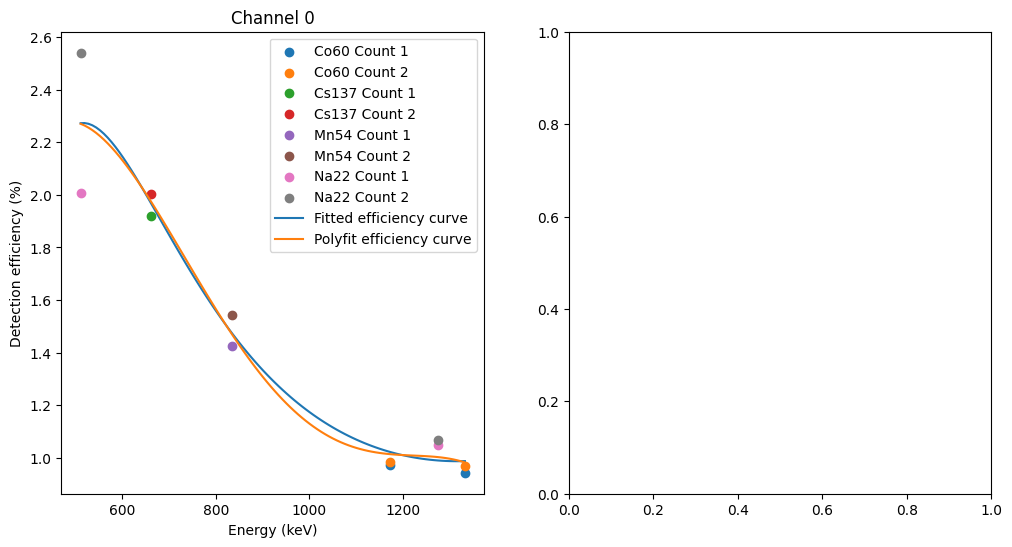

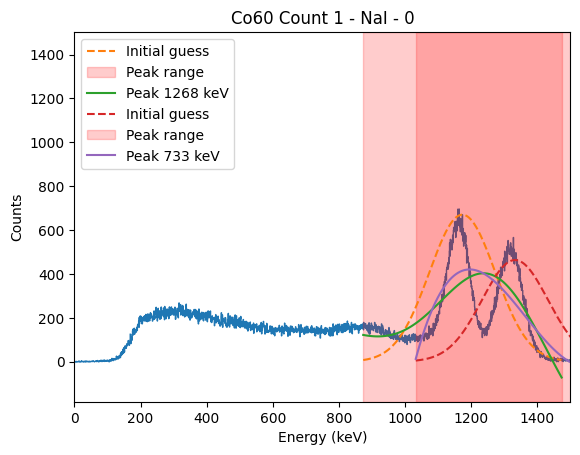

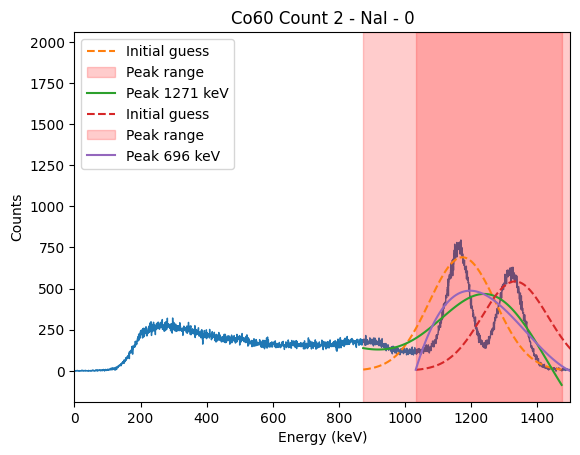

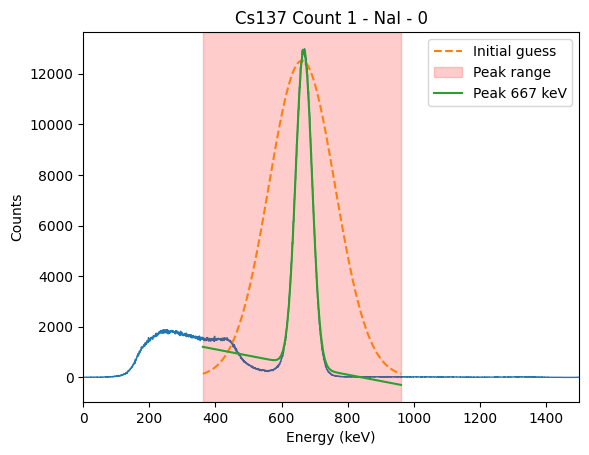

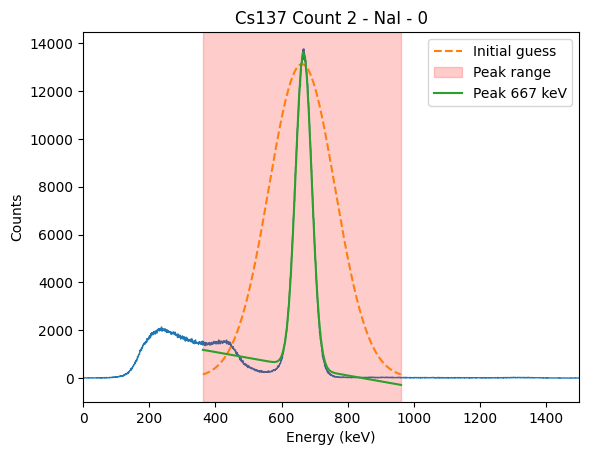

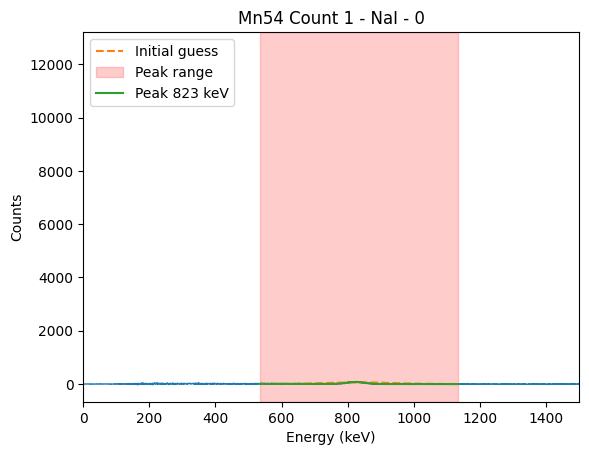

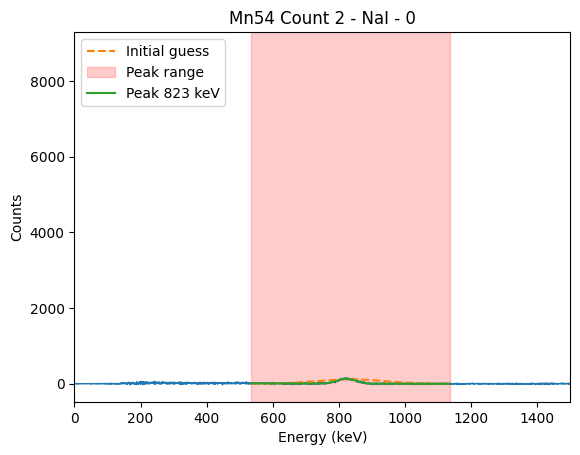

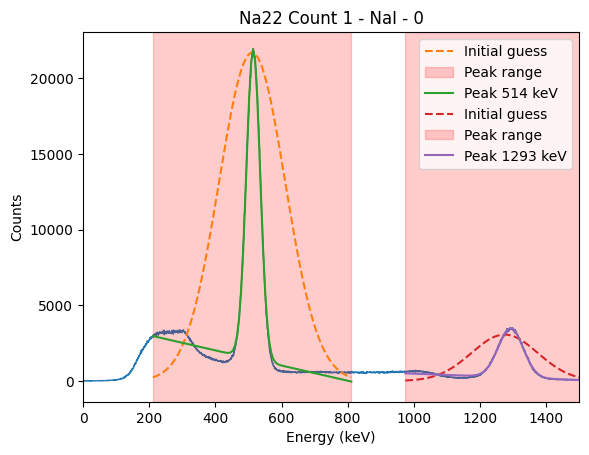

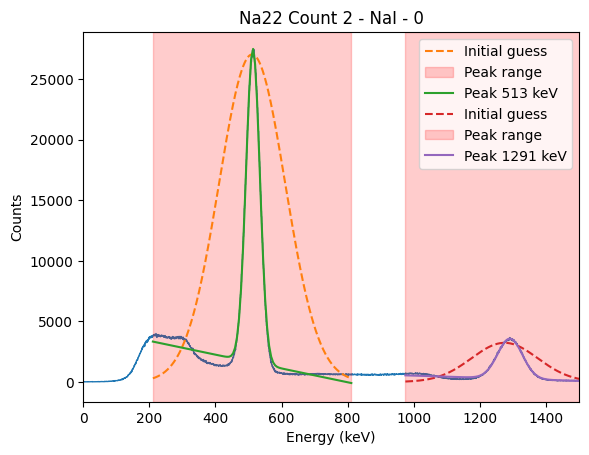

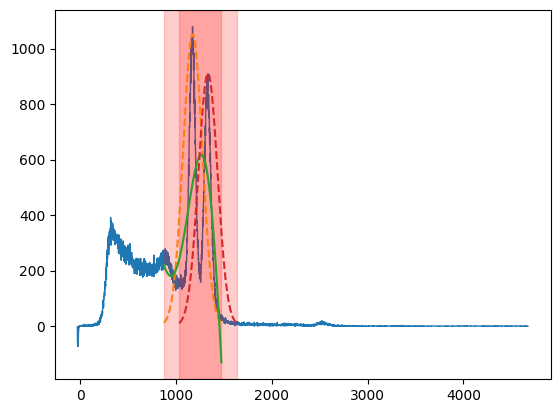

In [ ]:
from scipy.optimize import curve_fit

channels = []
efficiency_coeffs = {}
measurement = list(check_source_measurements["NaI"].values())[0]

search_widths = np.arange(20, 50, 2)
# for search_width in search_widths:
# search_width = 32
threshold_overlap = 20
for detector in measurement.detectors:
    channels.append(detector.channel_nb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i,ch in enumerate(channels):
    background_detector = background_meas["NaI"].get_detector(ch)
    energies = []
    efficiencies = []
    for name, measurement in check_source_measurements["NaI"].items():
        check_source_detector = measurement.get_detector(ch)
        hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector, bins=None)
        calibrated_bin_edges = np.polyval(calibration_coeffs[ch], bin_edges)

        # plot the histogram
        fig2,ax2 = plt.subplots()
        ax2.stairs(hist, calibrated_bin_edges)
        # ax2.set_xlim(left=0, right=500)

        # print('notebook search_width:', search_width, ' threshold_overlap:', threshold_overlap)
        areas = get_multipeak_area(
            hist, 
            calibrated_bin_edges, 
            measurement.check_source.nuclide.energy, 
            search_width=300,
            threshold_overlap=threshold_overlap, 
            axes=ax2
        )
        if measurement.check_source.nuclide.name == "Mn54":
            print("\nMn54 areas:", areas, "\n")
        print(areas)
        ax2.set_xlabel("Energy (keV)")
        ax2.set_ylabel("Counts")
        ax2.set_title(f"{measurement.name} - NaI - {ch}")
        ax2.legend()
        ax2.set_xlim(left=0, right=1500)
        
        efficiency = measurement.compute_detection_efficiency(
            background_measurement=background_meas["NaI"],
            calibration_coeffs=calibration_coeffs[ch],
            channel_nb=ch,
            search_width=300,
        )
        energies += measurement.check_source.nuclide.energy
        efficiencies += list(efficiency)
        ax[i].scatter(
            measurement.check_source.nuclide.energy,
            efficiency * 100,
            label=name,
        )

    # Sort energies and efficiencies for fitting
    sorted_indices = np.argsort(energies)
    energies = np.array(energies)[sorted_indices]
    efficiencies = np.array(efficiencies)[sorted_indices]
    print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

    # Fit the efficiency curve
    popt, pcov = curve_fit(
        eff_curve_func,
        energies,
        efficiencies,
        p0=[-1, 1, 0, 0],
    )

    poly_coeff = np.polyfit(energies, efficiencies, 4)
    efficiency_coeffs[ch] = poly_coeff
    xs = np.linspace(
        energies[0],
        energies[-1],
        100,
    )
    ax[i].plot(
        xs,
        eff_curve_func(xs, *popt) * 100,
        label="Fitted efficiency curve",
    )

    ax[i].plot(
        xs,
        np.polyval(poly_coeff, xs) * 100,
        label="Polyfit efficiency curve",
    )
    ax[i].set_xlabel("Energy (keV)")
    ax[i].set_ylabel("Detection efficiency (%)")
    ax[i].set_title(f"Channel {ch}")
    ax[i].legend()
    # plt.ylim(bottom=0)
    print(popt)
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information is collected.

In [ ]:
all_neutron_rates = []
all_neutron_rates_err = []

In [ ]:
from process_foil_data import irradiations, time_generator_off

### Niobium Packet #3 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the various measurements of the Niobium Packet #3 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
print(foil_measurements["Nb Packet #6"])

NameError: name 'foil_measurements' is not defined

In [ ]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_name = "Nb Packet #6"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=15)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])


libra-toolbox bins length: 4097
libra-toolbox xvals: [3.19988179e+00 4.21972210e+00 5.23956241e+00 ... 4.17740627e+03
 4.17842611e+03 4.17944595e+03]
libra-toolbox hist[0, -1]:  46.71284037618102 0.0
libra-toolbox peak_ergs: [934.44]
Search start: 898  Search end: 928
libra-toolbox bins length: 4097
libra-toolbox xvals: [3.19988179e+00 4.21972210e+00 5.23956241e+00 ... 4.17740627e+03
 4.17842611e+03 4.17944595e+03]
libra-toolbox hist[0, -1]:  82.4157747868619 0.0
libra-toolbox peak_ergs: [934.44]
Search start: 898  Search end: 928
Count 1
	 Ch 0: Neutron rate: 8.851e+05 +/- 1.971e+04 n/s
Count 2
	 Ch 0: Neutron rate: 8.745e+05 +/- 1.661e+04 n/s


### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the various measurements of the Zirconium Packet #1 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
foil_name = "Zr Packet #1"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=15)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

libra-toolbox bins length: 4097
libra-toolbox xvals: [3.19988179e+00 4.21972210e+00 5.23956241e+00 ... 4.17740627e+03
 4.17842611e+03 4.17944595e+03]
libra-toolbox hist[0, -1]:  11.601720348216872 0.0
libra-toolbox peak_ergs: [909.15]
Search start: 874  Search end: 903
Count 1
	 Ch 0: Neutron rate: 1.253e+09 +/- 1.885e+07 n/s


### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [ ]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

Average neutron rate: 4.181e+08 ± 7.227e+08 n/s


In [ ]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")

Processed data file not found, creating it in ../../data/processed_data.json
Processed data stored in ../../data/processed_data.json
